Códigos utilizados para desenvolver algoritmo para o problema de Order Batching por adensamento de estoque.

# Funcionamento do código:
O código possui 4 partes principais.

Na primeira parte é feito o carregamento, a validação, a extração e a organização dos dados que serão utilizados. Esses dados são organizados em andares corredores e caixas disponíveis na planilha.

Na segunda parte é feito um cálculo total de peças por corredor e andar e a organização dos corredores de cada andar. A ideia do código é priorizar a alocação de corredores mais "cheios" nas ondas para que cada onda tenha o menor número de corredores, minimizando assim a área de picking.

Na terceira parte se encontra a formação das ondas e a alocação desses corredores nas ondas. Nessa etapa é feita a distribuição dos corredores respeitando o limite máximo de 6000 peças por onda e quando uma onda não comporta mais nenhum corredor inteiramente, isto é, quando ela irá passar de 6000 peças, uma nova onda é criada.

Na última parte temos o cálculo da área dessa onda que é feita somando a diferença do maior corredor ímpar com o menor e a diferença do maior corredor par com o menor par, além de ser aplicado uma "penalidade" para ondas que utilizam mais de um andar. Depois disso são exibidos os resultados obtidos.

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Carregar a planilha
planilha = pd.read_excel("estoque.xlsx")

# Validar dados
if planilha.isnull().any().any():
    raise ValueError("Planilha contém valores nulos.")

# Agrupar dados
andares = sorted(planilha['ANDAR'].unique())  # Ordenar andares em ordem crescente
corredores = [(row['ANDAR'], row['CORREDOR']) for _, row in planilha.iterrows()]
caixas = planilha['SKU'].unique()

# Calcular o total de peças por corredor
total_pecas_por_corredor = {}
for (andar, corredor) in corredores:
    total_pecas = planilha.loc[
        (planilha['ANDAR'] == andar) & (planilha['CORREDOR'] == corredor),
        'PECAS'
    ].sum()
    total_pecas_por_corredor[(andar, corredor)] = total_pecas

# Configuração inicial
capacidade_picking = 6000  # Limite máximo de peças por onda

# Verificar proximidade dos SKUs com tolerância para outliers
sku_proximidade = {}
for sku in caixas:
    locais = planilha.loc[planilha['SKU'] == sku, ['ANDAR', 'CORREDOR']].sort_values(by=['ANDAR', 'CORREDOR'])
    total_caixas = len(locais)

    if total_caixas > 1:
        # Calcular distância máxima entre qualquer duas caixas do SKU
        distancia_maxima = max(locais['CORREDOR']) - min(locais['CORREDOR'])

        # Contar quantas caixas estão dentro do raio de 20 corredores de todas as outras
        proximas = sum(
            abs(locais.iloc[i]['CORREDOR'] - locais.iloc[j]['CORREDOR']) <= 20
            for i in range(total_caixas) for j in range(i + 1, total_caixas)
        )

        # Proporção de caixas que estão próximas
        proporcao_proximas = proximas / (total_caixas * (total_caixas - 1) / 2)  # Percentual de pares próximos

        # Considera "próximo" se ≥ 90% dos pares estiverem a ≤ 20 corredores
        sku_proximidade[sku] = proporcao_proximas >= 0.9
    else:
        # Se houver apenas uma caixa desse SKU, ele já está "próximo" por definição
        sku_proximidade[sku] = True

# Decidir estratégia de formação de ondas com base na maioria dos SKUs
total_skus = len(sku_proximidade)
skus_proximos = sum(1 for prox in sku_proximidade.values() if prox)

print("Formando ondas com base nos SKUs com maior número de peças.")

# Criar lista de SKUs ordenados por maior quantidade de peças
skus_ordenados = sorted(
    [(sku, planilha.loc[planilha['SKU'] == sku, 'PECAS'].sum()) for sku in caixas],
    key=lambda x: x[1], reverse=True
)

corredores_restantes = [(a, c, sku, p) for a, c, sku, p in zip(
    planilha['ANDAR'], planilha['CORREDOR'], planilha['SKU'], planilha['PECAS']
)]

# Inicializar as ondas
ondas = []
onda_atual = 0
capacidade_onda_atual = 0
corredores_na_onda_atual = []
skus_na_onda_atual = []

# Alocar corredores por andar ou por SKU
while corredores_restantes:
    adicionou_corredor = False

    i = 0
    while i < len(corredores_restantes):
        andar, corredor, sku, total_pecas = corredores_restantes[i]

        if capacidade_onda_atual + total_pecas <= capacidade_picking:
            capacidade_onda_atual += total_pecas
            corredores_na_onda_atual.append((andar, corredor))
            if sku:
                skus_na_onda_atual.append(sku)
            corredores_restantes.pop(i)
            adicionou_corredor = True
        else:
            i += 1

    # Se não conseguimos adicionar mais corredores, finaliza a onda e cria uma nova
    if not adicionou_corredor:
        ondas.append({
            "onda": onda_atual + 1,
            "corredores_usados": corredores_na_onda_atual,
            "total_pecas": capacidade_onda_atual,
            "skus": list(set(skus_na_onda_atual))  # Evita SKUs repetidos na exibição
        })
        onda_atual += 1
        capacidade_onda_atual = 0
        corredores_na_onda_atual = []
        skus_na_onda_atual = []

# Adicionar a última onda
if corredores_na_onda_atual:
    ondas.append({
        "onda": onda_atual + 1,
        "corredores_usados": corredores_na_onda_atual,
        "total_pecas": capacidade_onda_atual,
        "skus": list(set(skus_na_onda_atual))
    })

# Função para calcular a área de picking com penalidade por múltiplos andares
def calcular_area_de_picking(corredores_na_onda):
    area_total = 0
    corredores_por_andar = {}

    # Agrupar corredores por andar
    for andar, corredor in corredores_na_onda:
        if andar not in corredores_por_andar:
            corredores_por_andar[andar] = []
        corredores_por_andar[andar].append(corredor)

    # Calcular área para cada andar
    for andar, corredores in corredores_por_andar.items():
        corredores_impares = sorted([c for c in corredores if c % 2 == 1])
        corredores_pares = sorted([c for c in corredores if c % 2 == 0])

        area_andar = 0
        if corredores_impares:
            area_andar += ((max(corredores_impares) - min(corredores_impares)) / 2 + 1)
        if corredores_pares:
            area_andar += ((max(corredores_pares) - min(corredores_pares)) / 2 + 1)

        area_total += area_andar

    # Adicionar penalidade se mais de um andar for usado
    num_andares_utilizados = len(corredores_por_andar)
    area_total += 10 * (num_andares_utilizados - 1)

    return area_total


total = 0
for onda in ondas:
    area_picking = calcular_area_de_picking(onda['corredores_usados'])

    # Remover corredores duplicados e ordenar
    corredores_unicos = sorted(set(onda['corredores_usados']))

    print(f"Onda {onda['onda']}:")
    print(f"  Corredores usados: {corredores_unicos}")  # Agora sem repetição
    print(f"  SKUs na onda: {onda['skus']}")
    print(f"  Total de peças na onda: {onda['total_pecas']}")
    print(f"  Área de picking: {area_picking}")
    print()

    total += area_picking

print(f"Área média de picking com penalizações: {total / len(ondas)}")
print("Processamento concluído!")

# Gráficos
Os códigos abaixo servem para plotar alguns gráficos que trazem alguns insights sobre o algoritmo rodado.

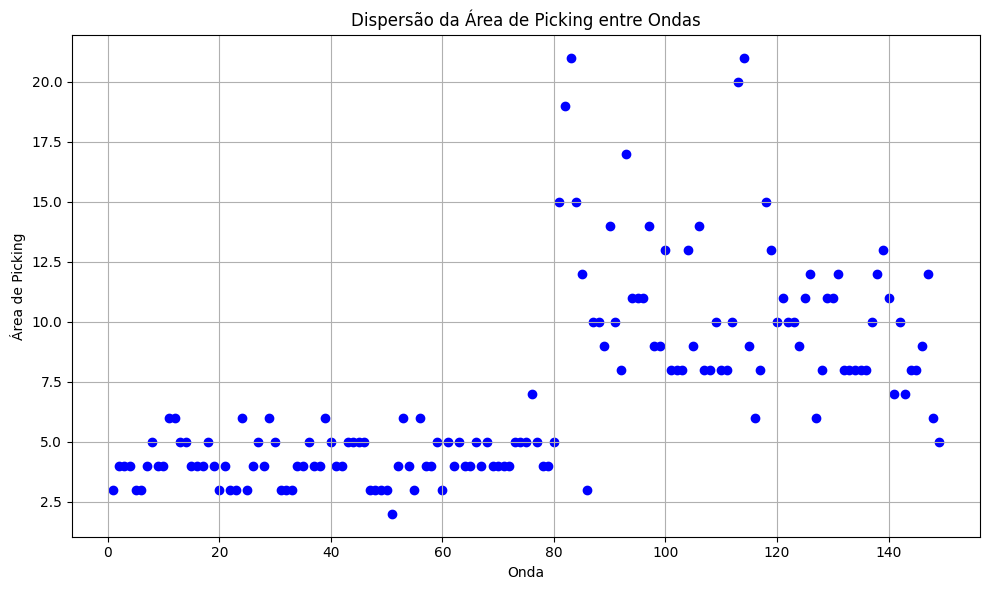

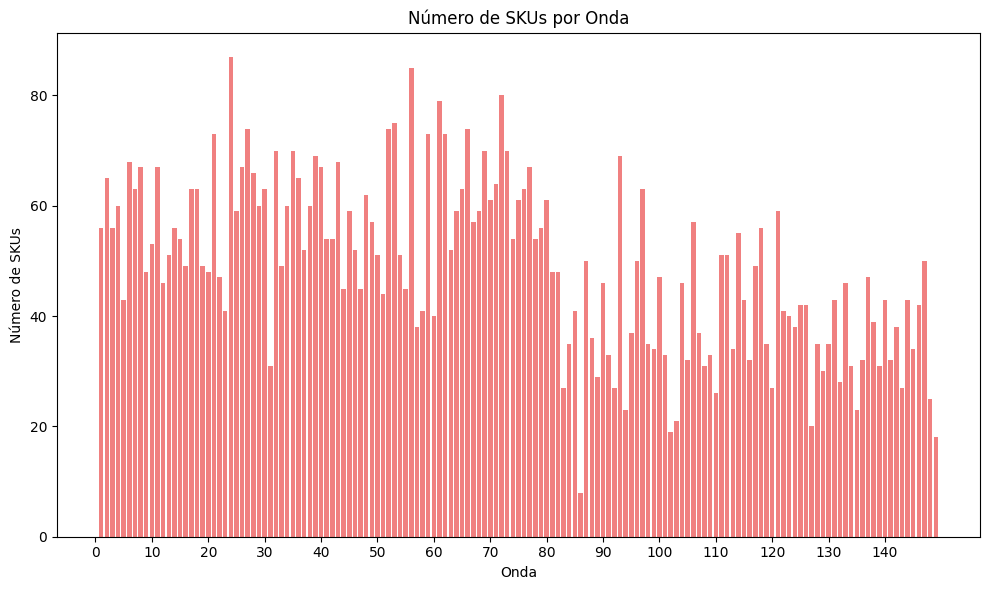

In [28]:
# Exibir resultados com a área de picking
# Calcular a área de picking para cada onda e verificar
ondas_areas = []
for onda in ondas:
    area_picking = calcular_area_de_picking(onda['corredores_usados'])
    ondas_areas.append(area_picking)
# Verificar se temos dados suficientes para plotar
if ondas_areas:
    # Gráfico de dispersão da área de picking entre ondas
    plt.figure(figsize=(10, 6))
    plt.scatter(range(1, len(ondas) + 1), ondas_areas, color='b', label='Área de Picking')
    plt.title('Dispersão da Área de Picking entre Ondas')
    plt.xlabel('Onda')
    plt.ylabel('Área de Picking')
    plt.grid(True)
    plt.tight_layout()
    plt.show()
else:
    print("Nenhuma onda foi gerada ou a área de picking está vazia.")

# Calcular o número de SKUs por onda
skus_por_onda = []
for onda in ondas:
    skus_unicos = set(onda['skus'])  # Remover SKUs duplicados
    skus_por_onda.append(len(skus_unicos))  # Contar o número de SKUs únicos

# Criar gráfico de barras para SKUs por onda
plt.figure(figsize=(10, 6))
plt.bar(range(1, len(ondas) + 1), skus_por_onda, color='lightcoral')

plt.title('Número de SKUs por Onda')
plt.xlabel('Onda')
plt.ylabel('Número de SKUs')

# Ajustar os ticks no eixo X para mostrar apenas intervalos
intervalo_ticks = range(0, len(ondas) + 1, 10)  # Exibe a cada ~10 ondas
plt.xticks(intervalo_ticks)

plt.tight_layout()
plt.show()

# Auxiliar
O código abaixo serve para randomizar o CD fornecido inicialmente e gerar uma nova planilha. Note que isso pode criar configurações de CDs EXTREMAMENTE desorganizadas, o que pode aumentar tremendamente o tempo de execução e a memória dos códigos produzidos.

In [26]:
import pandas as pd
import random

# Carregar a planilha
arquivo_entrada = "estoque.xlsx"
planilha = pd.read_excel(arquivo_entrada)

# Garantir que a coluna 'CORREDOR' existe, se não, criar
if 'CORREDOR' not in planilha.columns:
    raise ValueError("A planilha não contém a coluna 'CORREDOR'.")

# Preencher a coluna 'CORREDOR' com valores aleatórios entre 1 e 166
planilha['CORREDOR'] = [random.randint(1, 166) for _ in range(len(planilha))]

# Ordenar por 'ANDAR' e 'CORREDOR'
planilha = planilha.sort_values(by=['ANDAR', 'CORREDOR']).reset_index(drop=True)

# Salvar a planilha modificada
arquivo_saida = "estoque_modificado.xlsx"
planilha.to_excel(arquivo_saida, index=False)

print(f"Planilha salva como '{arquivo_saida}' ")


Planilha salva como 'estoque_modificado.xlsx' 
